In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [392]:
X_train = np.load("train_x.npy")
y_train = np.load("train_y.npy")
X_test_real = np.load("test_x.npy")

In [393]:
X_train,y_train

(array([[1.        , 0.89005238, 0.60558462, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.79310346, 0.46666667, ..., 0.        , 0.        ,
         0.        ],
        [0.9222222 , 0.68148148, 0.04814815, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.91876209, 0.84912962, 0.52417797, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97916669, 0.61174244, ..., 0.        , 0.        ,
         0.        ],
        [0.91778773, 0.70104635, 0.34230193, ..., 0.        , 0.        ,
         0.        ]]),
 array([0., 4., 0., ..., 0., 0., 0.]))

<AxesSubplot:ylabel='count'>

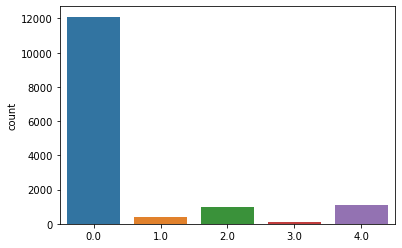

In [394]:
sns.countplot(x=y_train)

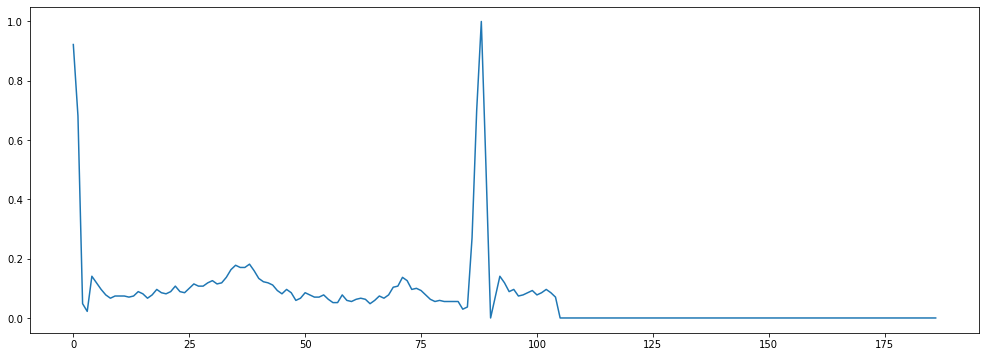

In [395]:
plt.figure(figsize = (17,6))
plt.plot(Xf_train[2])

(60510, 187)


(array([[1.        , 0.89005238, 0.60558462, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.79310346, 0.46666667, ..., 0.        , 0.        ,
         0.        ],
        [0.9222222 , 0.68148148, 0.04814815, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.78066485, 0.57022653, 0.5240637 , ..., 0.        , 0.        ,
         0.        ],
        [0.66190101, 0.55532693, 0.43663833, ..., 0.        , 0.        ,
         0.        ],
        [0.52852487, 0.4293997 , 0.39102919, ..., 0.        , 0.        ,
         0.        ]]),
 array([0., 4., 0., ..., 4., 4., 4.]))

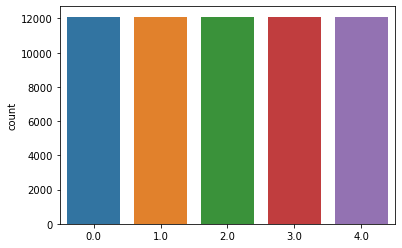

In [396]:
#!pip install imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(X_res.shape)
sns.countplot(x=y_res)
X_res,y_res

In [397]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.33, random_state=42)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)


In [398]:
import tensorflow as tf

classes = 5

model = tf.keras.models.Sequential([
    
    tf.keras.layers.Normalization(input_shape=(187,1)),

    tf.keras.layers.Conv1D(64,6,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=3,strides=2),
    
    tf.keras.layers.Conv1D(64,6,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    
    tf.keras.layers.Conv1D(64,6,activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(pool_size=2,strides=2),
    
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    
    tf.keras.layers.Dense(classes,activation='softmax')
    
    
])

In [399]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_26 (Normaliza  (None, 187, 1)           3         
 tion)                                                           
                                                                 
 conv1d_88 (Conv1D)          (None, 187, 64)           448       
                                                                 
 batch_normalization_108 (Ba  (None, 187, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_88 (MaxPoolin  (None, 93, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_89 (Conv1D)          (None, 93, 64)            24640     
                                                     

In [400]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [401]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy',f1]
)

In [402]:
print(X_train.shape)
print(X_test.shape)

(40541, 187)
(19969, 187)


In [403]:
model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(filepath="{epoch:02d}-{val_accuracy:.2f}.hdf5", save_best_only=True),
        
    ],
    use_multiprocessing=True,
    workers=8,
    epochs=20
)

Epoch 1/20
317/317 [==============================] - 37s 107ms/step - loss: 0.5037 - accuracy: 0.8308 - f1: 0.8264 - val_loss: 3.5389 - val_accuracy: 0.1961 - val_f1: 0.2008
Epoch 2/20
317/317 [==============================] - 28s 90ms/step - loss: 0.1887 - accuracy: 0.9388 - f1: 0.9391 - val_loss: 0.4813 - val_accuracy: 0.8324 - val_f1: 0.8347
Epoch 3/20
317/317 [==============================] - 27s 86ms/step - loss: 0.1155 - accuracy: 0.9643 - f1: 0.9646 - val_loss: 0.1340 - val_accuracy: 0.9535 - val_f1: 0.9539
Epoch 4/20
317/317 [==============================] - 27s 86ms/step - loss: 0.0885 - accuracy: 0.9720 - f1: 0.9720 - val_loss: 0.0879 - val_accuracy: 0.9714 - val_f1: 0.9719
Epoch 5/20
317/317 [==============================] - 28s 88ms/step - loss: 0.0692 - accuracy: 0.9793 - f1: 0.9794 - val_loss: 0.2090 - val_accuracy: 0.9265 - val_f1: 0.9268
Epoch 6/20
317/317 [==============================] - 29s 90ms/step - loss: 0.0558 - accuracy: 0.9821 - f1: 0.9822 - val_loss: 0.

In [404]:
y_pred = model.predict(X_test_real)
y_pred

226/226 [==============================] - 1s 5ms/step


array([[9.9566603e-01, 4.2855907e-03, 1.9584746e-05, 9.4361340e-06,
        1.9341962e-05],
       [9.9999809e-01, 1.8151383e-06, 7.8757857e-08, 9.5539558e-09,
        1.9830706e-08],
       [9.9999988e-01, 6.0597110e-08, 1.8594397e-08, 2.9332803e-09,
        7.6920772e-09],
       ...,
       [9.9999321e-01, 1.7703684e-06, 7.7583087e-07, 3.8219359e-06,
        3.0912381e-07],
       [9.9999869e-01, 1.2823837e-06, 4.4353953e-08, 1.1135848e-08,
        4.6188400e-09],
       [9.9999738e-01, 2.1124483e-06, 4.6311135e-07, 2.5648971e-08,
        5.7843419e-08]], dtype=float32)

In [405]:
y_pred_new=np.array([list(x).index(max(x)) for x in y_pred])
y_pred_csv = pd.DataFrame()

y_pred_csv["Answer"] = np.array(y_pred_new).astype(int).astype(str)
y_pred_csv.rename_axis('ID',inplace=True)

y_pred_csv.to_csv("submission.csv")

y_pred_csv

,Answer
ID,
0,0
1,0
2,0
3,2
4,0
...,...
7220,0
7221,2
7222,0
